# Dog Breed Classifier with HPO/Debugging/Profiling/Deployment

This notebook leverages Sagemaker's tools to perform training, hyperparameter optimization, debugging, profiling, deployment and inference, applied to a computer vision classification problem (dog breed classifier).

Flow:
- Data setup
- Developing the model
- Train with several hyperparam combinations to find the best (HPO)
- Retrain with the best parameters and Debugging/Profiling 
- Generate a profiling report
- Deploy the model to an endpoint
- Perform inference by querying the endpoint

In [2]:
# DONE: Install any packages that you might need
!pip install smdebug

In [5]:
# DONE: Import any packages that you might need
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()

# bucket = sagemaker_session.default_bucket()
bucket = 'edgarin-mlend'
prj_prefix = 'prj-dogbreed'
data_prefix = f"{prj_prefix}/dogImages"
data_s3_uri = f"s3://{bucket}/{data_prefix}"

role = sagemaker.get_execution_role()
data_s3_uri

's3://edgarin-mlend/prj-dogbreed/dogImages'

# About the dataset

This dataset consists of dog images of 133 different breeds, split in train, test and validation sets, following the following file structure:
- train/
  - breed1/
    - some-dog.jpg
    - another-dog.jpg
  - breed2/
    - cutie-dog.jpg  
    ...
  - breed133/  
    ...  
- test/  
   (same as train)
- valid/  
   (same as train)

For example, some-dog.jpg is a dog image of breed1.


In [ ]:
#DONE: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [ ]:
!aws s3 cp dogImages s3://edgarin-mlend/prj-dogbreed/ --recursive

In [4]:
# Alternative, upload the zip and use lambda to unzip directly (code not here)
sagemaker_session.upload_data('./dogImages.zip', bucket=bucket, key_prefix=prj_prefix)
# The unzipping is done with Lambda separately

's3://edgarin-mlend/prj-dogbreed/dogImages.zip'

## ML model
The model code can be found in `hpo.py`. It uses a pretrained DenseNet121 model, with a customized classifier in the last layers.

## Hyperparameter Tuning
For hyperparameter tuning, we chose the following params:
- Batch size: 128 or 256
- Learning rate: Between 0.001 and 0.1 (continous): 
- Epochs: Between 2 and 5

16 different combinations will be tried by HyperParameterTuner.

#### Test the train script in isolation

In [2]:
!SM_HOSTS='[]' SM_CURRENT_HOST='' SM_MODEL_DIR='./model' SM_CHANNEL_TRAIN='./dogImages-express/valid' SM_CHANNEL_TEST='./dogImages-express/test' SM_NUM_GPUS=1  python3 train_model.py --batch-size 64 --test-batch-size 64 --epochs 1 --lr 0.003

ALL ARGS:  Namespace(batch_size=64, current_host='', epochs=1, hosts=[], lr=0.003, model_dir='./model', num_gpus=1, test_batch_size=64, test_dir='./dogImages-express/test', train_dir='./dogImages-express/valid')
Start training...
[2022-01-20 02:25:06.092 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:322 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-20 02:25:06.395 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:322 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
  Epoch 1.. Epoch progress: 0.0%.. Batch avg train loss: 0.076.. 
  Epoch 1.. Epoch progress: 71.4%.. Batch avg train loss: 0.076.. 
Epoch 1.. Progress: 0.0% Train loss: 0.083 Test loss: 0.075 Test accuracy: 0.143
Final test accuracy: 0.143
done


In [3]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

# DONE: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    'batch-size': CategoricalParameter([128, 256]),
    'lr': ContinuousParameter(0.001, 0.01),
    'epochs': IntegerParameter(2, 5),
}

objective_metric_name = "Average test accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Average test accuracy", "Regex": "Test accuracy: ([0-9\\.]+)"}]



In [23]:
# DONE: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

# DONE: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
    #instance_type='ml.p3.2xlarge',  
)

# DONE: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=16,
    max_parallel_jobs=4,
    objective_type=objective_type
)

In [6]:
# DONE: Fit your HP Tuner
# # s3://edgarin-mlend/prj-dogbreed/dogImages/
predictor = tuner.fit({
    'train': f'{data_s3_uri}/train',
    'test': f'{data_s3_uri}/test',
}) # DONE: Remember to include your data channels

....................................................


In [5]:
# To get the tuner 'offline' (another notebook session)
tuner = HyperparameterTuner.attach('pytorch-training-220120-0318')

In [7]:
# DONE: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-20 08:34:15 Starting - Preparing the instances for training
2022-01-20 08:34:15 Downloading - Downloading input data
2022-01-20 08:34:15 Training - Training image download completed. Training in progress.
2022-01-20 08:34:15 Uploading - Uploading generated training model
2022-01-20 08:34:15 Completed - Training job completed


{'_tuning_objective_metric': '"Average test accuracy"',
 'batch-size': '"128"',
 'epochs': '5',
 'lr': '0.002528913920826402',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-01-20-03-18-30-959"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-784712499272/pytorch-training-2022-01-20-03-18-30-959/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [3]:
# DONE: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    # Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()), # Added from stable
    Rule.sagemaker(rule_configs.poor_weight_initialization()), # Added from stable
    # Rule.sagemaker(rule_configs.loss_not_decreasing()),    
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

# create the profiler and debugger configs
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={
        'train.save_interval': '10',
        'eval.save_interval': '1'
    }
)

In [7]:
# Got values from HPO
best_hyperparameters = {
    'batch-size': 128,
    'epochs': 5,
    'lr': 0.0025
}

In [8]:
# DONE: Create and fit an estimator
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
  base_job_name='prj-dogbreed-trjob',
  role=sagemaker.get_execution_role(),
  # instance_type='ml.m5.large',    
  instance_type='ml.p3.2xlarge',
  instance_count=2,
  entry_point='./train_model.py',
  framework_version='1.8',
  py_version='py36',
  hyperparameters=best_hyperparameters,  
  rules=rules,
  debugger_hook_config=debugger_config,
  profiler_config=profiler_config  
)

estimator.fit({
    'train': f'{data_s3_uri}/train',
    'test': f'{data_s3_uri}/test',
}, wait=True)

2022-01-22 19:26:10 Starting - Starting the training job...
2022-01-22 19:26:40 Starting - Launching requested ML instancesOverfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-01-22 19:28:00 Starting - Preparing the instances for training......
2022-01-22 19:29:06 Downloading - Downloading input data............
2022-01-22 19:31:02 Training - Downloading the training image...............
2022-01-22 19:33:43 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-22 19:33:29,771 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-22 19:33:29,793 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-22 19:33:42,439 sagemaker_pytorch_container.training INFO     Invoking us

In [9]:
# estimator = PyTorch.attach('prj-dogbreed-trjob-2022-01-21-20-07-42-574', sagemaker_session)

In [10]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial

[2022-01-22 19:46:11.228 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:1290 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-22 19:46:11.250 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:1290 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-433745147480/prj-dogbreed-trjob-2022-01-22-19-26-09-701/debug-output
[2022-01-22 19:46:13.790 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:1290 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-22 19:46:14.814 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:1290 INFO trial.py:210] Loaded all steps


<smdebug.trials.s3_trial.S3Trial object at 0x7f9184254f28>:(
    name=debug-output,
    path=s3://sagemaker-us-east-1-433745147480/prj-dogbreed-trjob-2022-01-22-19-26-09-701/debug-output/,
    steps=[0, 10, 20, 30, 40, 50, 53, 54, 55, 56, 64, 74, 84, 94, 104, 110, 111, 112, 113, 118, 128, 138, 148, 158, 167, 168, 169, 170, 172, 182, 192, 202, 212, 222, 224, 225, 226, 227, 236, 246, 256, 266, 276, 281, 282, 283, 284, 285, 286, 287, 288],
    collections=['gradients', 'biases', 'losses', 'all', 'weights', 'default', 'relu_input'],
    tensor_names=['NLLLoss_output_0', 'NLLLoss_output_1', 'transition1.relu_input_0', 'transition2.relu_input_0', 'transition3.relu_input_0'],
)

In [11]:
trial.tensor_names()

['NLLLoss_output_0',
 'NLLLoss_output_1',
 'transition1.relu_input_0',
 'transition2.relu_input_0',
 'transition3.relu_input_0']

In [12]:
for tensor_name in trial.tensor_names():
    train_datapoints = len(trial.tensor(tensor_name).steps(mode=ModeKeys.TRAIN))
    eval_datapoints = len(trial.tensor(tensor_name).steps(mode=ModeKeys.EVAL))
    print(tensor_name, train_datapoints, eval_datapoints)

NLLLoss_output_0 27 24
NLLLoss_output_1 27 24
transition1.relu_input_0 1 1
transition2.relu_input_0 1 1
transition3.relu_input_0 1 1


In [13]:
loss_tensor_name = "NLLLoss_output_0"
train_datapoints = len(trial.tensor(loss_tensor_name).steps(mode=ModeKeys.TRAIN))
eval_datapoints = len(trial.tensor(loss_tensor_name).steps(mode=ModeKeys.EVAL))
print(train_datapoints, eval_datapoints)

27 24


In [14]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


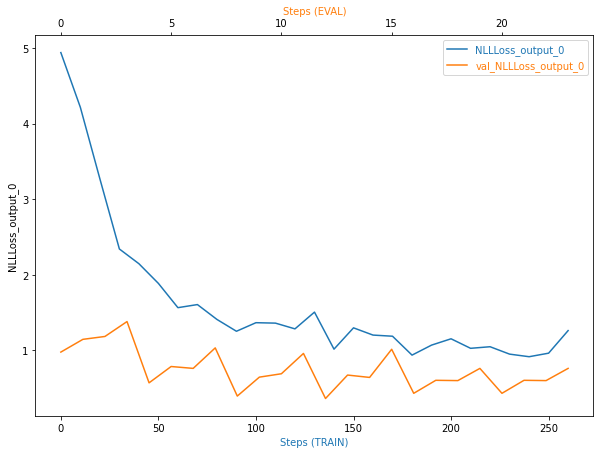

In [15]:
plot_tensor(trial, loss_tensor_name)

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Profiling

In [16]:
# TODO: Display the profiler output
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

training_job_name = estimator.latest_training_job.job_name

tj = TrainingJob(training_job_name, region = sagemaker_session.boto_region_name)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-433745147480/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-433745147480/prj-dogbreed-trjob-2022-01-22-19-26-09-701/profiler-output


Profiler data from system is available


In [17]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-01-22 19:46:20.819 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:1290 INFO metrics_reader_base.py:134] Getting 34 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-2', 'GPUUtilization-nodeid:algo-2', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-2', 'GPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


In [18]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-433745147480/prj-dogbreed-trjob-2022-01-22-19-26-09-701/rule-output


In [19]:
! aws s3 ls {rule_output_path} --recursive

2022-01-22 19:45:40     515678 prj-dogbreed-trjob-2022-01-22-19-26-09-701/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-22 19:45:39     388128 prj-dogbreed-trjob-2022-01-22-19-26-09-701/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-22 19:45:32        947 prj-dogbreed-trjob-2022-01-22-19-26-09-701/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-22 19:45:33      89123 prj-dogbreed-trjob-2022-01-22-19-26-09-701/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-22 19:45:33       1954 prj-dogbreed-trjob-2022-01-22-19-26-09-701/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-22 19:45:33        487 prj-dogbreed-trjob-2022-01-22-19-26-09-701/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-22 19:45:33      17965 prj-dogbreed-trjob-2022-01-22-19-26-09-701/rule-output/ProfilerReport/profiler-outp

In [20]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-433745147480/prj-dogbreed-trjob-2022-01-22-19-26-09-701/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-433745147480/prj-dogbreed-trjob-2022-01-22-19-26-09-701/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-433745147480/prj-dogbreed-trjob-2022-01-22-19-26-09-701/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-433745147480/prj-dogbreed-trjob-2022-01-22-19-26-09-701/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-433745147480/prj-dogbreed-trjob-202

In [21]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [140]:
# DONE: Create and fit an estimator
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
  base_job_name='prj-dogbreed-trjob',
  role=sagemaker.get_execution_role(),
  # instance_type='ml.m5.large',    
  instance_type='ml.p3.2xlarge',
  instance_count=1,
  entry_point='./train_model.py',
  # entry_point='./hpo.py',
  framework_version='1.8',
  py_version='py36',
  # framework_version='1.4.0',
  # py_version='py3',  
  hyperparameters={
    'batch-size': 128,
    'epochs': 1,
    'lr': 0.0025
  },  
  #rules=rules,
  debugger_hook_config=False,
  # profiler_config=False  
)

estimator.fit({
    'train': f'{data_s3_uri}/valid',
    'test': f'{data_s3_uri}/test',
}, wait=True)


2022-01-25 13:19:37 Starting - Starting the training job...
2022-01-25 13:20:01 Starting - Launching requested ML instancesProfilerReport-1643116777: InProgress
......
2022-01-25 13:21:01 Starting - Preparing the instances for training.........
2022-01-25 13:22:27 Downloading - Downloading input data...
2022-01-25 13:23:02 Training - Downloading the training image..............................
2022-01-25 13:28:03 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-25 13:27:57,904 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-25 13:27:57,927 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-25 13:27:59,382 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-25 13:28:00,040 sagemaker-training-toolkit INFO     Invoking user s

In [141]:
estimator.model_data

's3://sagemaker-us-east-1-784712499272/prj-dogbreed-trjob-2022-01-25-13-19-37-053/output/model.tar.gz'

In [142]:
model_location=estimator.model_data

import sagemaker
import boto3
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)


In [143]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


------!

len(img_bytes):  126800


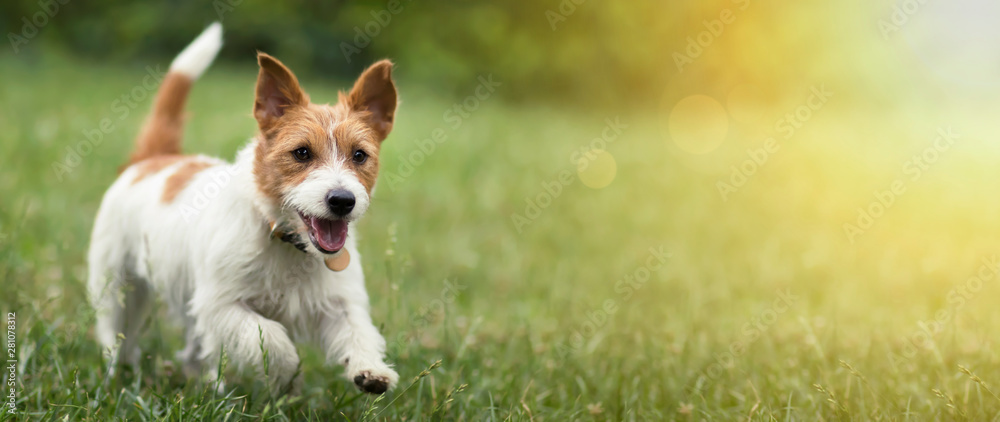

In [144]:
import requests
request_dict={ "url": "https://as2.ftcdn.net/v2/jpg/02/81/07/83/1000_F_281078312_PcISs3yKL9r70nCqvDkgOR17UBGIw97C.jpg" }
img_bytes = requests.get(request_dict['url']).content
# type(img_bytes)
print('len(img_bytes): ', len(img_bytes))

from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [145]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
response

[[-4.957036018371582,
  -5.139828681945801,
  -5.427165508270264,
  -4.514697551727295,
  -4.625660419464111,
  -4.612526893615723,
  -4.470405101776123,
  -4.403015613555908,
  -5.235504627227783,
  -4.962815284729004,
  -4.3750505447387695,
  -4.72395133972168,
  -4.585642337799072,
  -4.217391490936279,
  -5.133194446563721,
  -4.867118835449219,
  -4.7140631675720215,
  -4.988811016082764,
  -4.72163200378418,
  -4.905579566955566,
  -4.468426704406738,
  -5.064842224121094,
  -4.776956558227539,
  -5.727678298950195,
  -5.424144744873047,
  -5.784154891967773,
  -4.374414443969727,
  -5.154821395874023,
  -3.9047012329101562,
  -4.880630970001221,
  -4.456049919128418,
  -4.610811710357666,
  -5.4586286544799805,
  -4.2346014976501465,
  -5.284012794494629,
  -4.55059289932251,
  -4.372756481170654,
  -4.73646879196167,
  -4.242724895477295,
  -5.007852554321289,
  -4.682331085205078,
  -4.43297815322876,
  -4.905269145965576,
  -4.619532585144043,
  -4.883864402770996,
  -4.67088

In [146]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})
type(response2[0][0])


float

In [147]:
response2[0]

[-4.957036018371582,
 -5.139828681945801,
 -5.427165508270264,
 -4.514697551727295,
 -4.625660419464111,
 -4.612526893615723,
 -4.470405101776123,
 -4.403015613555908,
 -5.235504627227783,
 -4.962815284729004,
 -4.3750505447387695,
 -4.72395133972168,
 -4.585642337799072,
 -4.217391490936279,
 -5.133194446563721,
 -4.867118835449219,
 -4.7140631675720215,
 -4.988811016082764,
 -4.72163200378418,
 -4.905579566955566,
 -4.468426704406738,
 -5.064842224121094,
 -4.776956558227539,
 -5.727678298950195,
 -5.424144744873047,
 -5.784154891967773,
 -4.374414443969727,
 -5.154821395874023,
 -3.9047012329101562,
 -4.880630970001221,
 -4.456049919128418,
 -4.610811710357666,
 -5.4586286544799805,
 -4.2346014976501465,
 -5.284012794494629,
 -4.55059289932251,
 -4.372756481170654,
 -4.73646879196167,
 -4.242724895477295,
 -5.007852554321289,
 -4.682331085205078,
 -4.43297815322876,
 -4.905269145965576,
 -4.619532585144043,
 -4.883864402770996,
 -4.67088508605957,
 -5.058082103729248,
 -4.7221097946

In [148]:
import torch
import numpy as np
np.argmax(response, 1)

array([28])

In [149]:
'done 9:19'

'done 9:19'

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(2, 'ml.p3.2xlarge') # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()